# Easy 21: control
[(source code)](https://github.com/angelolovatto/rl-introduction-notebooks/blob/master/notebooks/Easy21%20-%20Control.ipynb)

The goal of this assignment is to apply reinforcement learning methods to a simple card game that we call _Easy21_. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non-standard.
* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one blackcard (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

## 1. Implementation of Easy21

You should write an environment that implements the game Easy21. Specifically, write a function, named `step`, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state s′ (which may be _terminal_ if the game is finished) and reward r. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting $(\gamma = 1)$. You should treat the dealer’s moves as part of the environment, i.e. calling _step_ with a _stick_ action will play out the dealer’s cards and return the final reward and terminal state.

---

The following is an implementation of the Easy21 environment, where two conventions were adopted:
* $A_t \in \{0, 1\}$, where 0 and 1 denote _stick_ and _hit_ respectively;
* $S_t = (s_d, s_p) \in \{0, \dots, 9\}\times\{0, \dots, 20\}$, where $s_d$ and $s_p$ denote the dealer's first card and the player's card sum, both subtracted by 1.

These conventions were used in order to adapt the implementation to OpenAI's Gym specifications. In the plots that follow, the dealer's first card and the player's sum are shifted in order to appear in the ranges 1-10 and 1-21 respectively.

In [1]:
import gym
import random
import numpy as np
from gym import spaces

class Easy21Env(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(10), spaces.Discrete(21)))
        self.action_space = spaces.Discrete(2)
        self.random = random.Random()
        
    def reset(self):
        self.state = (self.random.randrange(10), self.random.randrange(10))
        self.done = False
        return self.state
    
    def _draw_card(self):
        new_card = self.random.randrange(1, 11)
        return new_card if self.random.uniform(0, 1) > 1/3 else - new_card
    
    @staticmethod
    def _is_bust(card_sum):
        return card_sum not in range(21)

    def step(self, action):
        assert action in self.action_space
        assert not self.done, \
        "It looks like you're calling step() even though this "
        "environment has already returned done=True. You should "
        "always call reset() once you receive done=True."
        dealer_card, player_sum = self.state
        if action is 1:
            player_sum += self._draw_card()
            is_bust = self._is_bust(player_sum)
            self.state = (dealer_card, player_sum) if not is_bust else self.state
            reward = -1 if is_bust else 0
            self.done = is_bust
        else:
            dealer_sum = dealer_card
            while not self._is_bust(dealer_sum) and dealer_sum < 16:
                dealer_sum += self._draw_card()
            is_bust = self._is_bust(dealer_sum)
            sum_diff = player_sum - dealer_sum
            self.state = self.state 
            reward = 1 if is_bust or sum_diff > 0 else 0 if sum_diff is 0 else -1
            self.done = True
        return self.state, reward, self.done, {}
    
    def seed(self, seed=None):
        self.random.seed(seed)
        

env = Easy21Env()

Below are utility functions to handle state and action spaces. Since we're dealing with discrete state and action spaces, we'll consider value functions as 2d or 3d numpy arrays, whose indexes are the states or state-action pairs.

In [2]:
from itertools import product

def elements(space):
    if isinstance(space, spaces.Tuple):
        return product(*(elements(subspace) for subspace in space))
    elif isinstance(space, spaces.Discrete):
        return range(space.n)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))

def all_states(env):
    return elements(env.observation_space)

def all_actions(env):
    return elements(env.action_space)

def all_state_action_pairs(env):
    return product(all_states(env), all_actions(env))

def shape(space):
    if isinstance(space, spaces.Tuple):
        return sum((shape(subspace) for subspace in space), ())
    elif isinstance(space, spaces.Discrete):
        return (space.n,)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))    

def states_shape(env):
    return shape(env.observation_space)

def actions_shape(env):
    return shape(env.action_space)

def states_actions_shape(env):
    return states_shape(env) + actions_shape(env)

def qpi_array_from_dict(qpi):
    arr = np.empty(states_actions_shape(env))
    for state, action in all_state_action_pairs(env):
        arr[state][action] = qpi[state, action]
    return arr

def vpi_from_qpi(qpi):
    return qpi.max(axis=-1)

Below are utility functions to help plot the value functions returned by each control algorithm.

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
# mpl.rcParams['pgf.rcfonts'] = False


def state_value_data(vpi):
    x = np.arange(10) + 1
    y = np.arange(21) + 1
    x, y = np.meshgrid(x, y)
    return x, y, vpi.transpose()

def state_value_desc(ax, labels=True):
    if labels:
        ax.set_xlabel("Dealer's card")
        ax.set_ylabel("Player's sum")
        ax.set_zlabel("State value")
    ax.set_xlim([1, 10])
    ax.set_ylim([1, 21])
    ax.set_zlim([-1, 1])
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def state_value_surface(ax, vpi, *, labels=True):
    state_value_desc(ax, labels=labels)
    ax.plot_surface(*state_value_data(vpi), cmap=cm.coolwarm)

def state_value_wireframe(ax, vpi, labels=True):
    state_value_desc(ax, labels=labels)
    ax.plot_wireframe(*state_value_data(vpi), color='black')
    
def state_value_contour3D(ax, vpi, labels=True):
    state_value_desc(ax, labels=labels)
    ax.contour3D(*state_value_data(vpi), 50, cmap='binary')

## 2. Monte-Carlo Control in Easy21

Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use a time-varying scalar step-size of $\alpha_t = 1/N(s_t, a_t)$ and an $\epsilon$-greedy exploration strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ is a constant, $N(s)$ is the number of times that state $s$ has been visited, and $N(s,a)$ is the number of times that action a has been selected from state $s$. Feel free to choose an alternative value for $N_0$, if it helps producing better results. Plot the optimal value function $V^*(s) = \max_a Q^*(s, a)$ using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

<img src="https://github.com/angelolovatto/rl-introduction-notebooks/blob/master/notebooks/images/sutton_blackjack.png?raw=true" width="200">

---

In `DecayingEpsilonGreedyPolicy` we implement a policy which keeps track of the number of times each action has been taken in each state. This number can be incremented by calling `update_count` with the desired state-action pair. From this, the quantities $N(s)$ and $N(s, a)$ can be easily derived. The policy is $\epsilon$-greedy as defined above and thus takes an action-value function `qpi` as a construction argument.

In [4]:
from collections import Counter, defaultdict

class DecayingEpsilonGreedyPolicy(object):
    def __init__(self, env, qpi, n_zero=100):
        self._qpi = qpi
        self._n_zero = n_zero
        self._state_action_count = defaultdict(Counter)
        self._random = random.Random()
        self._random.seed(5788)
        
    def __call__(self, state):
        state_visits = sum(self._state_action_count[state].values())
        epsilon = self._n_zero / (self._n_zero + state_visits)
        if self._random.random() < epsilon:
            action = self._random.randrange(2)
        else:
            action = max(range(2), key=lambda a: self._qpi[state, a])
        return action
    
    def times_taken(self, state, action):
        return self._state_action_count[state][action]
    
    def update_count(self, state, action):
        self._state_action_count[state][action] += 1

The function `monte_carlo_control` implements the aforementioned algorithm. Notice that it uses the policy defined above and that we update its counter only after generating each episode. This done so that the policy does not change during the sampling step, as updating the counter would implicitly change the exploration factor $\epsilon_t$. Since Monte Carlo requires full returns sampled from the same policy, this would not be correct. 

The algorithm returns a list of checkpoints, which are pairs $(\# episodes, Q(s,a))$, so that we can analyse the obtained action-value estimates $Q(s, a) \approx Q^*(s, a)$ against the number of episodes sampled in the algorithm.

In [5]:
from tqdm import tnrange

def monte_carlo_control(env, episodes, checkpoint=None):
    if checkpoint is None:
        checkpoint = lambda i: i+1 == episodes
    checkpoints = []

    # Initialize all state values to 0
    qpi = dict.fromkeys(all_state_action_pairs(env), 0)
    # Initialize decaying epsilon greedy policy
    policy = DecayingEpsilonGreedyPolicy(env, qpi)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes'):
        # Generate an episode following policy
        done, state = False, env.reset()
        trajectory = []
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            
        # Precompute the returns for each timestep
        states, actions, rewards = zip(*trajectory)
        returns = np.cumsum(rewards[::-1])[::-1]
        for state, action, _return in zip(states, actions, returns):
            policy.update_count(state, action)
            alpha = 1 / policy.times_taken(state, action)
            qpi[state, action] += alpha * (_return - qpi[state, action])
            
        if checkpoint(episode):
            checkpoints.append((episode+1, qpi_array_from_dict(qpi)))
    return checkpoints

In [6]:
def qstar_x_episodes(control_algorithm, **alg_kwargs):
    save_at = [10**i for i in range(2, 8)]
    checkpoint = lambda i: i+1 in save_at
    env.seed(5788)
    checkpoints = control_algorithm(env, 10**7, checkpoint=checkpoint, **alg_kwargs)
    return checkpoints

def plot_vstar_episodes(checkpoints):
    num_plots = len(checkpoints)
    num_horizontal = min(num_plots, 3)
    num_vertical = num_plots // 3 + 1
    fig = plt.figure(figsize=[num_horizontal * 6.4, num_vertical * 4.8])
    for i, (episodes, qstar) in enumerate(checkpoints):
        ax = fig.add_subplot(num_vertical, num_horizontal, i+1, projection='3d')
        ax.set_title("{} episodes".format(episodes))
        state_value_wireframe(ax, vpi_from_qpi(qstar), labels=(i==num_plots-1))

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

In [7]:
mc_checkpoints = qstar_x_episodes(monte_carlo_control)

Next, we plot the state-value functions obtained after different numbers of episodes.

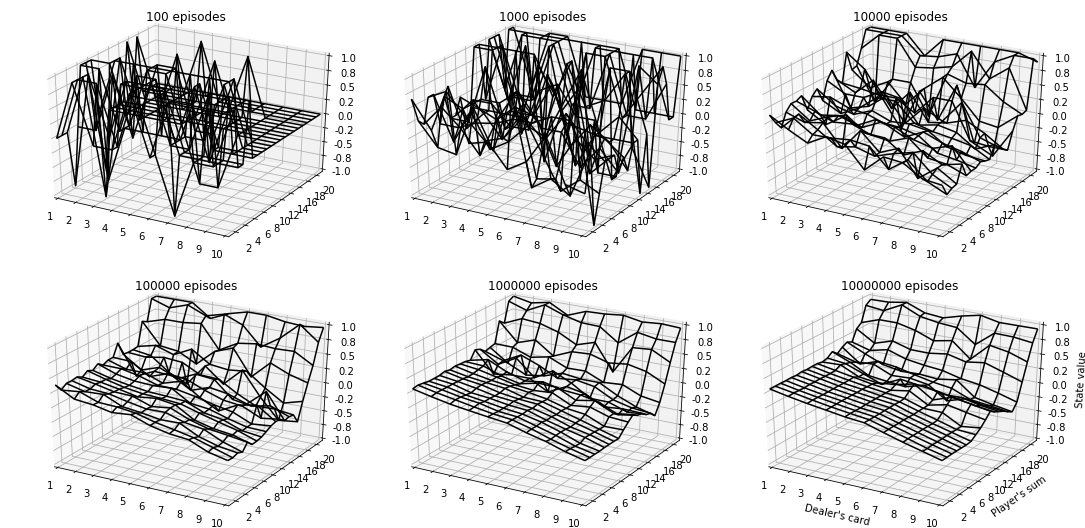

In [8]:
plot_vstar_episodes(mc_checkpoints)

## 3. TD Learning in Easy21

Implement Sarsa($\lambda$) in 21s. Initialise the value function to zero. Use the same step-size and exploration schedules as in the previous section. Run the algorithm with parameter values $\lambda\in\{0, 0.1, 0.2, \dots, 1\}$. Stop each run after 1000 episodes and report the mean-squared error 􏰊$\sum_{s,a}(Q(s, a) − Q^*(s, a))^2$ over all states $s$ and actions $a$, comparing the true values $Q^∗(s,a)$ computed in the previous section with the estimated values $Q(s, a)$ computed by Sarsa. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of mean-squared error against episode number.

---

Here we define a second policy, `NPDecayingEpsilonGreedyPolicy`, which uses a numpy array to keep track of the number of times each action has been taken in each state. Since Sarsa($\lambda$) updates all state-action pairs for every step taken in the environment (see the pseudocode from lecture 5 below), we use numpy arrays to vectorize computation, instead of looping over all possible pairs.
<img src="https://github.com/angelolovatto/rl-introduction-notebooks/blob/master/notebooks/images/sarsa_lambda.png?raw=true" width="600">

In [9]:
class NPDecayingEpsilonGreedyPolicy(object):
    def __init__(self, env, qpi, n_zero=100):
        self._qpi = qpi
        self._n_zero = n_zero
        self._state_action_count = np.zeros(
            states_actions_shape(env), dtype=np.int32)
        self._random = random.Random()
        self._random.seed(5788)
        
    def __call__(self, state):
        state_visits = self._state_action_count[state].sum().item() + 1
        epsilon = self._n_zero / (self._n_zero + state_visits)
        if self._random.random() < epsilon:
            action = self._random.randrange(2)
        else:
            action = self._qpi[state].argmax().item()
        self._state_action_count[state][action] += 1
        return action
    
    def times_taken(self, state, action):
        return self._state_action_count[state][action]
    
def sarsa_lambda(env, episodes, *, checkpoint=None, lam=0, noprog=False):
    if checkpoint is None:
        checkpoint = lambda i: i+1 == episodes
    checkpoints = []

    # Initialize all state values to 0
    qpi = np.zeros(states_actions_shape(env))
    # Initialize decaying epsilon greedy policy
    policy = NPDecayingEpsilonGreedyPolicy(env, qpi)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes', disable=noprog):
        eligibility = np.zeros(states_actions_shape(env))
        done, state = False, env.reset()
        action = policy(state)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state)
            next_state_action_value = 0 if done else qpi[next_state][next_action]
            delta = reward + next_state_action_value - qpi[state][action]
            eligibility[state][action] += 1
            
            indexes = eligibility > 0
            alpha = 1 / policy._state_action_count[indexes]
            qpi[indexes] += alpha * delta * eligibility[indexes]
            eligibility[indexes] *= lam

            state, action = next_state, next_action

        if checkpoint(episode):
            checkpoints.append((episode+1, qpi.copy()))
    return checkpoints

As requested, we plot the mean-squared error of the value functions obtained for $\lambda\in\{0, 0.1, 0.2, \dots, 1\}$ after 1000 episodes each with the final value function obtained with monte carlo control in the last section.

In [10]:
def mean_squared_error(arr1, arr2):
    return np.square(arr1 - arr2).mean().item()

_, qstar = mc_checkpoints[-1]
lambdas = [x/10 for x in range(11)]
lam_ms_errors = []
for lam in lambdas:
    env.seed(5788)
    _, qlam = sarsa_lambda(env, 1000, lam=lam, noprog=True)[0]
    lam_ms_errors.append(mean_squared_error(qlam, qstar))

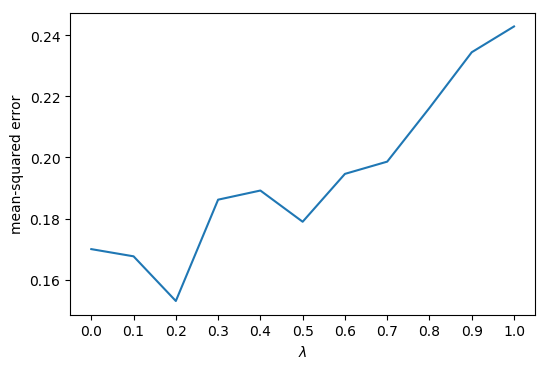

In [11]:
fig = plt.figure(dpi=100)
plt.plot(lambdas, lam_ms_errors)
plt.xticks(lambdas)
plt.xlabel("$\lambda$")
plt.ylabel("mean-squared error")
plt.show()

In addition, we plot the value functions obtained by Sarsa($\lambda = 0.2$), since it seems to have converged faster in 1000 episodes than with other values of $\lambda$.

In [12]:
lam02_checkpoints = qstar_x_episodes(sarsa_lambda, lam=0.2)

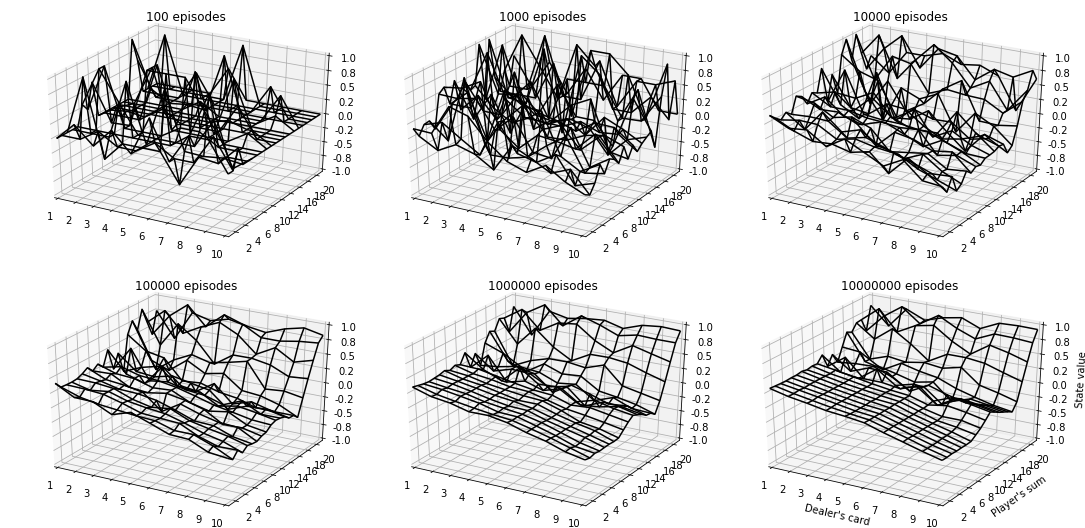

In [13]:
plot_vstar_episodes(lam02_checkpoints)

Interestingly, it seems that the value function estimated by Sarsa($\lambda = 0.2$) does not change much between 100 thousand and a million episodes. Below we plot the final values returned by Monte Carlo and Sarsa($\lambda = 0.2$) from left to right. This direct comparison seems to indicate that Monte Carlo produces a smoother final value, which might be an indication of the bias in Sarsa due to bootstrapping.

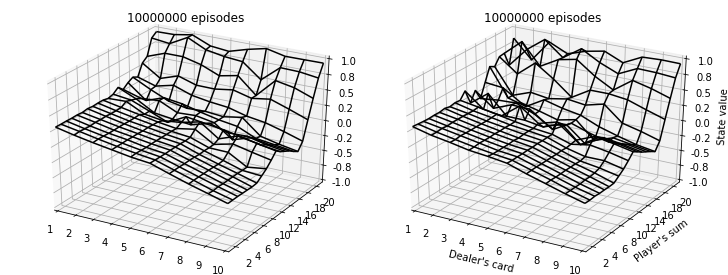

In [21]:
plot_vstar_episodes([mc_checkpoints[-1], lam02_checkpoints[-1]])

Next, as requested, for $\lambda = 1$ and $\lambda = 0$ we plot the mean squared error against episode number over 1000 episodes.

In [14]:
checkpoint = lambda _: True

env.seed(5788)
lam0_checkpoints = sarsa_lambda(
    env, 1000, lam=0, checkpoint=checkpoint, noprog=True)
lam0_mse_errors = list(map(
    lambda ckpt: mean_squared_error(ckpt[1], qstar),
    lam0_checkpoints))
del lam0_checkpoints

env.seed(5788)
lam1_checkpoints = sarsa_lambda(
    env, 1000, lam=1, checkpoint=checkpoint, noprog=True)
lam1_mse_errors = list(map(
    lambda ckpt: mean_squared_error(ckpt[1], qstar),
    lam1_checkpoints))
del lam1_checkpoints

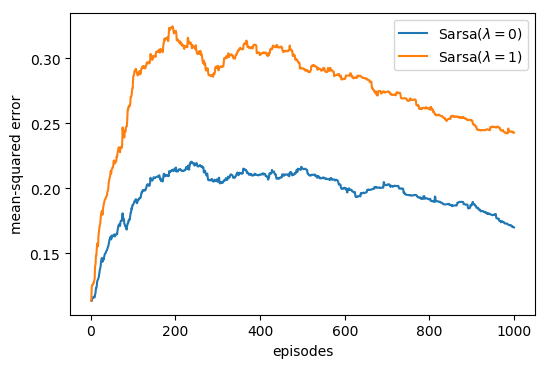

In [15]:
fig = plt.figure(dpi=100)
plt.plot(range(1, 1001), lam0_mse_errors, label="Sarsa($\lambda = 0$)")
plt.plot(range(1, 1001), lam1_mse_errors, label="Sarsa($\lambda = 1$)")
plt.xlabel("episodes")
plt.ylabel("mean-squared error")
plt.legend()
plt.show()

The graph shows that Sarsa($\lambda = 0$) is much quicker to converge to the optimal action-value function, assuming the one returned by Monte Carlo is reasonably accurate. We hypothesize that this is due to the lower variance that a higher degree of bootstrapping provides, and demonstrates one of the advantages of bootstraping in this environment.

### Bonus: Q-Learning

Since the value functions obtained still appear to be a bit noisy, we decided to test the Q-Learning control algorithm to see if it is possible to obtain more stable estimates of the optimal value function. The function `q_learning` below implements the algorithm, based on the following pseudocode from lecture 5, which is much simpler than the two previous ones.

<img src="https://github.com/angelolovatto/rl-introduction-notebooks/blob/master/notebooks/images/q_learning.png?raw=true" width=600>

In [16]:
def q_learning(env, episodes, checkpoint=None):
    if checkpoint is None:
        checkpoint = lambda i: i+1 == episodes
    checkpoints = []
    
    # Initialize all state values to 0
    qmu = dict.fromkeys(all_state_action_pairs(env), 0)
    # Initialize decaying epsilon greedy policy
    policy = DecayingEpsilonGreedyPolicy(env, qmu)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes'):
        done, state = False, env.reset()
        while not done:
            action = policy(state)
            policy.update_count(state, action)
            next_state, reward, done, _ = env.step(action)

            max_next_q_value = 0 if done else max(
                qmu[next_state, action] for action in all_actions(env))
            delta = reward + max_next_q_value - qmu[state, action]
            alpha = 1 / policy.times_taken(state, action)
            qmu[state, action] += alpha * delta

            state = next_state

        if checkpoint(episode):
            checkpoints.append((episode+1, qpi_array_from_dict(qmu)))
    return checkpoints

In [17]:
ql_checkpoints = qstar_x_episodes(q_learning)

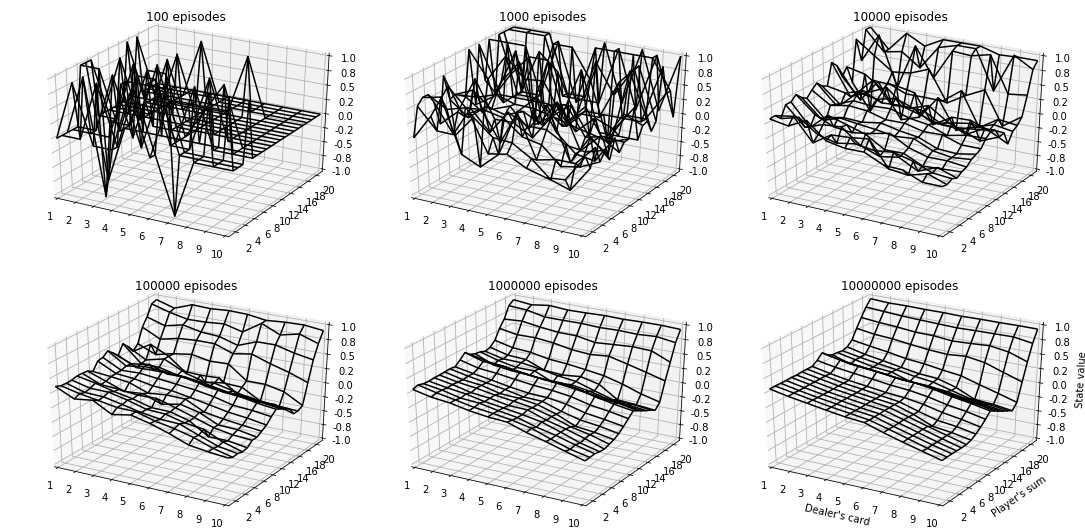

In [18]:
plot_vstar_episodes(ql_checkpoints)

Surprisingly, Q-Learning converges much faster than the previous two algorithms, judging by the smoothness of the last two plots. Below we plot, from left to right, the final value functions obtained by the three algorithms, further showing the advantage of Q-Learning.

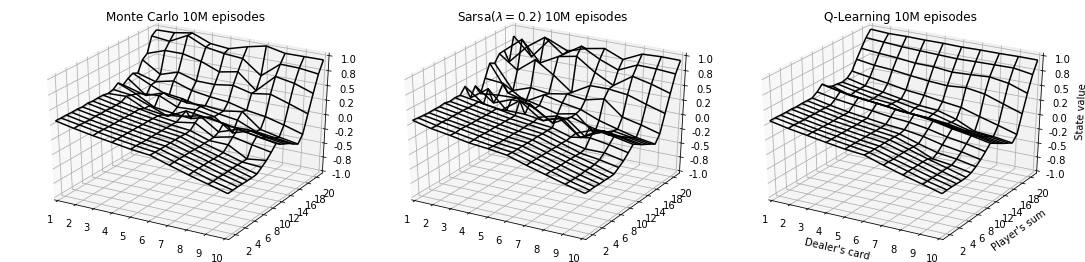

In [26]:
_, final_mc = mc_checkpoints[-1]
_, final_lam02 = lam02_checkpoints[-1]
_, final_ql = ql_checkpoints[-1]
plot_vstar_episodes([
    ("Monte Carlo 10M", final_mc), 
    ("Sarsa($\lambda = 0.2$) 10M", final_lam02), 
    ("Q-Learning 10M", final_ql)])

Finally, we plot the final value and correponding policy returned by Q-Learning to see where the agent hits (black) or sticks (white).

In [19]:
import seaborn as sns
from matplotlib import cm

def plot_final_policy_value(qstar):
    pistar = qstar.argmax(axis=-1)
    vstar = qstar.max(axis=-1)

    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title("optimal value")
    state_value_wireframe(ax, vstar)

    ax = fig.add_subplot(1, 2, 2)
    fig = sns.heatmap(np.flipud(pistar.transpose()), ax=ax, cmap="binary",
                      xticklabels=range(1,11), yticklabels=range(21,0,-1))
    fig.set_xlabel("Dealer's card")
    fig.set_ylabel("Player's sum")
    fig.set_title("optimal policy")

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

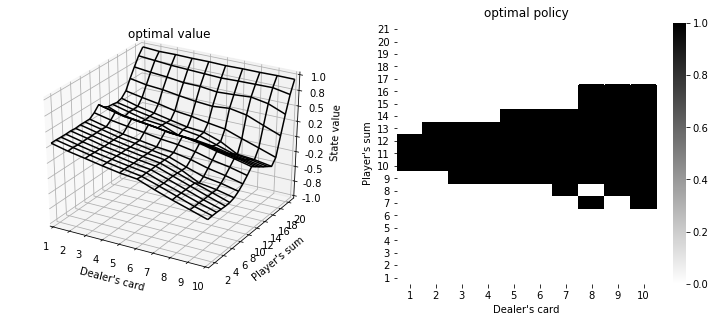

In [20]:
_, qstar = ql_checkpoints[-1]
plot_final_policy_value(qstar)

## 5. Discussion

Discuss the choice of algorithm used in the previous section.
* What are the pros and cons of bootstrapping in Easy21?
* Would you expect bootstrapping to help more in blackjack or Easy21? Why?

---

Answering the questions the above in order.
* From the experiments, it seems that bootstrapping helps in achieving faster convergence (in number of episodes), possibly because of the lower variance of the _TD target_ hinted at by Silver in his classes. However, as we've seem with Sarsa, there seems to be a problem with the value function once it converges: it appears to be noisier than the one returned by Monte Carlo. This is possibly due to the _bias_ of the TD target, also discussed in the classes. However, in the case of Q-Learning, which is an off-policy TD method, the value function converges faster and produces a visually better estimate of the optimal value. It is therefore unclear if the disadvantages discussed above are an inherent characteristic of bootstrapping methods.
* I would expect bootstrapping to help more in Easy21. This game may have longer episodes than Blackjack, due to the possibility of adding and subtracting to the player's sum several times before either sticking or going bust. Bootstrapping helps updating value estimates sooner by not waiting until an episode finishes _and_ provides lower variance targets that may accelerate convergence. Thus, I expect the benefits of this class of methods to be more apparent in Easy21.